# problem 1
We solve $u_t = u_{xx}$ on $x\in[0,1]$, $t\ge 0$ with
- Initial condition: $u(x,0)=\sin(\tfrac{\pi}{2}x)+\tfrac12\sin(2\pi x)$
- Boundary conditions: $u(0,t)=0$, $u(1,t)=e^{-\pi^2 t/4}$.

We implement Forward Euler with two choices of the CFL-like parameter $\mu = \frac{\Delta t}{\Delta x^2}$:
- $\mu=0.5$ (on the stability boundary for FE)
- $\mu=0.509$ (slightly beyond, expected to be unstable).
---


# Derivation of the Forward Euler update 
Starting from $u_t = u_{xx}$.

1. Introduce grid points and discrete times:
   - $x_i = i\,\Delta x$, $i=0,1,\dots,N_x-1$.
   - $t^n = n\,\Delta t$, $n=0,1,2,\dots$.
   - Let $u^n_i \approx u(x_i, t^n)$.

2. Approximate derivatives:
   - Time derivative (Forward Euler):
     $$ u_t(x_i, t^n) \approx \frac{u^{n+1}_i - u^n_i}{\Delta t}. $$
   - Second spatial derivative (centered difference, second-order):
     $$ u_{xx}(x_i, t^n) \approx \frac{u^n_{i+1} - 2u^n_i + u^n_{i-1}}{\Delta x^2}. $$

3. Substitute into the PDE at $(x_i, t^n)$:
   $$ \frac{u^{n+1}_i - u^n_i}{\Delta t} = \frac{u^n_{i+1} - 2u^n_i + u^n_{i-1}}{\Delta x^2}. $$

4. Solve for $u^{n+1}_i$:
   $$ u^{n+1}_i = u^n_i + \frac{\Delta t}{\Delta x^2}(u^n_{i+1} - 2u^n_i + u^n_{i-1}). $$

5. Define the dimensionless parameter $\mu = \Delta t / \Delta x^2$ to obtain:
   $$ u^{n+1}_i = u^n_i + \mu (u^n_{i+1} - 2u^n_i + u^n_{i-1}). $$

6. Boundary points $i=0$ and $i=N_x-1$ are not updated by this formula; they are set by the Dirichlet boundary conditions at each time level.


Stability consideration:
- For Forward Euler applied to diffusion, the condition is $\mu \le 1/2$.
- We run two cases: $\mu=0.5$ (on the boundary, expected to be stable) and $\mu=0.509$ (slightly beyond, expected to be unstable).
---

# Derivation of the exact solution

We construct $u_\text{exact}(x,t)$ using separation of variables for the heat equation $u_t=u_{xx}$.

1) Single-mode ansatz:
- Assume a mode of the form $u(x,t)=A(t)\,\sin(\alpha x)$.
- Substitute into $u_t=u_{xx}$:
  $$ A'(t)\sin(\alpha x) = A(t)(-\alpha^2)\sin(\alpha x) \;\Rightarrow\; A'(t) = -\alpha^2 A(t). $$
- Solution: $A(t)=C\,e^{-\alpha^2 t}$. Therefore each sine mode decays exponentially with rate $\alpha^2$.

2) Our initial condition is a sum of two sines:
$$ u(x,0)=\sin\!\left(\tfrac{\pi}{2}x\right) + \tfrac{1}{2}\sin(2\pi x). $$
It is natural to evolve each mode independently with its own decay:
$$ u_\text{exact}(x,t)= e^{-(\frac{\pi}{2})^2 t}\,\sin\!\left(\tfrac{\pi}{2}x\right) + \tfrac{1}{2}\,e^{-(2\pi)^2 t}\,\sin(2\pi x). $$
Equivalently,
$$ u_\text{exact}(x,t)= e^{-\pi^2 t/4}\,\sin\!\left(\tfrac{\pi}{2}x\right) + \tfrac{1}{2}\,e^{-(2\pi)^2 t}\,\sin(2\pi x). $$



In [61]:
# Setup and exact reference function
import numpy as np
import matplotlib.pyplot as plt

pi = np.pi

def u_initial(x):
    return np.sin(0.5*pi*x) + 0.5*np.sin(2*pi*x)

def u_exact(x, t):
    # Construct using modal decay and boundary at x=1: sin(pi/2*1)=1
    term1 = np.exp(-(pi**2)/4 * t) * np.sin(0.5*pi*x)
    term2 = 0.5 * np.exp(- (2*pi)**2 * t) * np.sin(2*pi*x)
    return term1 + term2

def forward_euler_heat(mu, Nx=101, T_final=0.1):
    """
    Forward Euler for u_t = u_xx with Dirichlet BCs:
    u(0,t)=0, u(1,t)=exp(-pi^2 t/4).

    Contract:
    - Inputs: mu (float), Nx (int grid points including boundaries), T_final (float)
    - Outputs: x (Nx array), u (Nx array at final time), t_hist (list), E_hist (list of max abs value), unstable_flag (bool)
    Error modes: if mu>0.5, FE is unstable -> expect growth; we mark unstable_flag when max abs exceeds 10x initial max.
    """
    x = np.linspace(0.0, 1.0, Nx)
    dx = x[1] - x[0]
    dt = mu * dx**2
    steps = int(np.ceil(T_final/dt))
    dt = T_final/steps  # adjust to reach T_final exactly while keeping mu ~ desired
    mu = dt / dx**2

    u = u_initial(x)
    t = 0.0

    t_hist = [t]
    E_hist = [np.max(np.abs(u))]

    # indices 1..Nx-2 are interior
    for n in range(steps):
        # enforce Dirichlet boundary values at the current time level
        u[0] = 0.0
        u[-1] = np.exp(-(pi**2)/4 * t)
        # compute new interior via FE
        u_new = u.copy()
        for i in range(1, Nx-1):
            u_new[i] = u[i] + mu * (u[i+1] - 2*u[i] + u[i-1])
        # update time and solution
        t += dt
        # apply boundary at new time level for consistency
        u_new[0] = 0.0
        u_new[-1] = np.exp(-(pi**2)/4 * t)
        u = u_new
        t_hist.append(t)
        E_hist.append(np.max(np.abs(u)))

    unstable_flag = (np.max(E_hist) > 10.0 * E_hist[0])
    return x, u, np.array(t_hist), np.array(E_hist), unstable_flag, mu, steps

# Demo parameters
Nx = 201
T_final = 0.1
mu_stable = 0.5
mu_unstable = 0.509

x_stable, u_stable, t_hist_stable, E_hist_stable, unstable_stable, mu_stable, steps_stable = forward_euler_heat(mu_stable, Nx=Nx, T_final=T_final)
x_unst, u_unst, t_hist_unst, E_hist_unst, unstable_flag, mu_unstable, steps_unst = forward_euler_heat(mu_unstable, Nx=Nx, T_final=T_final)

print(f"Resolved with Nx={Nx}, dx={(x_stable[1]-x_stable[0]):.5f}")
print(f"Stable run (target mu=0.5) -> actual mu={mu_stable:.6f}, steps={steps_stable}")
print(f"Unstable run (target mu=0.509) -> actual mu={mu_unstable:.6f}, steps={steps_unst}, unstable_flag={unstable_flag}")

Resolved with Nx=201, dx=0.00500
Stable run (target mu=0.5) -> actual mu=0.500000, steps=8000
Unstable run (target mu=0.509) -> actual mu=0.508971, steps=7859, unstable_flag=True


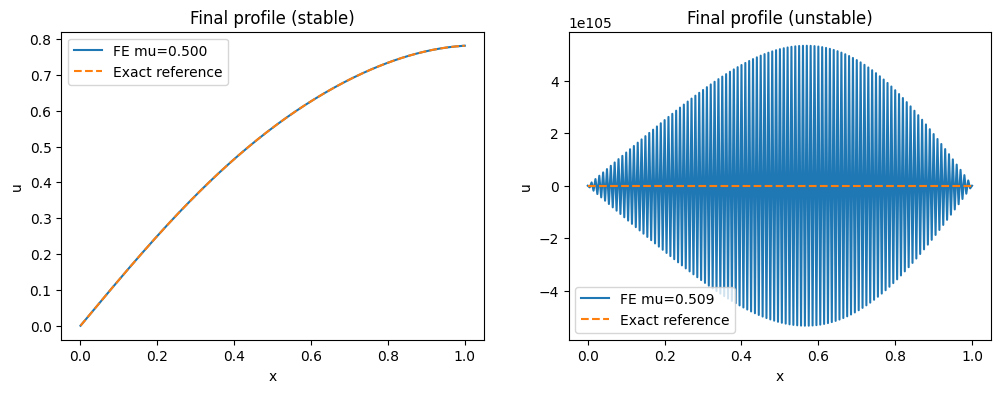

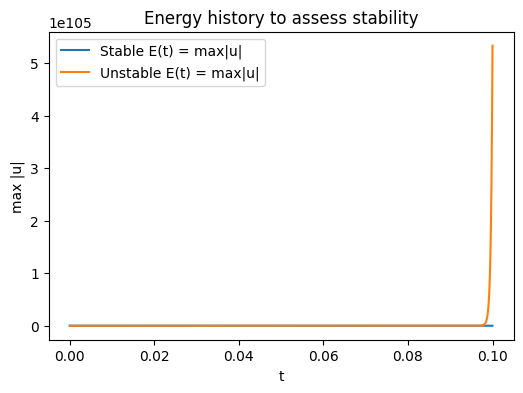

In [62]:
# Visual diagnostics: profiles and energy histories
import matplotlib.pyplot as plt

# Plot final profiles vs exact reference for stable and unstable runs
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

# Stable
ax[0].plot(x_stable, u_stable, label=f'FE mu={mu_stable:.3f}')
ax[0].plot(x_stable, u_exact(x_stable, t_hist_stable[-1]), '--', label='Exact reference')
ax[0].set_title('Final profile (stable)')
ax[0].set_xlabel('x')
ax[0].set_ylabel('u')
ax[0].legend()

# Unstable
ax[1].plot(x_unst, u_unst, label=f'FE mu={mu_unstable:.3f}')
ax[1].plot(x_unst, u_exact(x_unst, t_hist_unst[-1]), '--', label='Exact reference')
ax[1].set_title('Final profile (unstable)')
ax[1].set_xlabel('x')
ax[1].set_ylabel('u')
ax[1].legend()

plt.show()

# Energy history (max abs) for both runs
plt.figure(figsize=(6,4))
plt.plot(t_hist_stable, E_hist_stable, label='Stable E(t) = max|u|')
plt.plot(t_hist_unst, E_hist_unst, label='Unstable E(t) = max|u|')
plt.xlabel('t')
plt.ylabel('max |u|')
plt.title('Energy history to assess stability')
plt.legend()
plt.show()


In [63]:
# Accuracy metrics at final time (stable run)
import numpy as np

# Final time for stable run
T_final_stable = float(t_hist_stable[-1])

# Exact reference and error
u_ref_stable = u_exact(x_stable, T_final_stable)
err_vec = u_stable - u_ref_stable

# Infinity norm only
dx_stable = float(x_stable[1] - x_stable[0])
err_inf = float(np.max(np.abs(err_vec)))

# Boundary residuals
res_left = float(abs(u_stable[0] - 0.0))
res_right = float(abs(u_stable[-1] - np.exp(-(np.pi**2)/4 * T_final_stable)))

print(f"Stable run final time T={T_final_stable:.6f}")
print(f"Max-norm error ||u-u_ref||_inf = {err_inf:.6e}")
print(f"Boundary residuals: left={res_left:.3e}, right={res_right:.3e}")


Stable run final time T=0.100000
Max-norm error ||u-u_ref||_inf = 6.972311e-06
Boundary residuals: left=0.000e+00, right=0.000e+00


Convergence data (mu=0.5, T=0.1):
Nx=  51  dx=0.020000  err_inf=1.115e-04  steps=500
Nx= 101  dx=0.010000  err_inf=2.788e-05  steps=2000
Nx= 201  dx=0.005000  err_inf=6.972e-06  steps=8000
Nx= 301  dx=0.003333  err_inf=3.099e-06  steps=18000


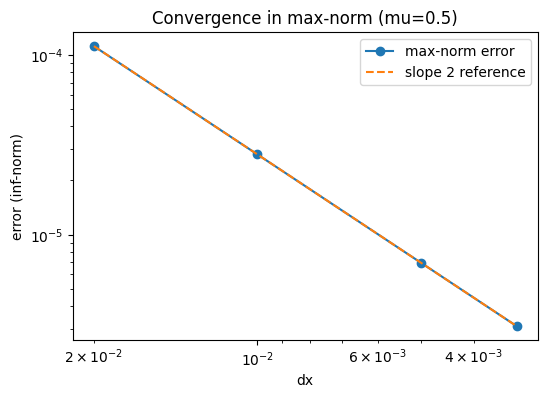

In [64]:
# Convergence study for stable Forward Euler (mu=0.5)
import numpy as np
import matplotlib.pyplot as plt

mu = 0.5
T_final_conv = 0.1
Nx_list = [51, 101, 201, 301]

DX = []
ERR_INF = []
STEPS = []

for Nx_i in Nx_list:
    x_i, u_i, t_hist_i, E_hist_i, unstable_i, mu_i, steps_i = forward_euler_heat(mu, Nx=Nx_i, T_final=T_final_conv)
    dx_i = float(x_i[1] - x_i[0])
    u_ref_i = u_exact(x_i, float(t_hist_i[-1]))
    err_i = u_i - u_ref_i
    err_inf_i = float(np.max(np.abs(err_i)))

    DX.append(dx_i)
    ERR_INF.append(err_inf_i)
    STEPS.append(steps_i)

# Print a small table
print("Convergence data (mu=0.5, T=0.1):")
for dx_i, Nx_i, ei, s in zip(DX, Nx_list, ERR_INF, STEPS):
    print(f"Nx={Nx_i:4d}  dx={dx_i:.6f}  err_inf={ei:.3e}  steps={s}")

# Log-log plot with slope-2 reference line
k_inf = ERR_INF[-1] / (DX[-1]**2)
ref_inf = [k_inf * (d**2) for d in DX]
plt.figure(figsize=(6,4))
plt.loglog(DX, ERR_INF, 'o-', label='max-norm error')
plt.loglog(DX, ref_inf, '--', label='slope 2 reference')
plt.gca().invert_xaxis()
plt.xlabel('dx')
plt.ylabel('error (inf-norm)')
plt.title('Convergence in max-norm (mu=0.5)')
plt.legend()
plt.show()


# Problem 2 :

We solve $u_t=u_{xx}$ on $[0,1]$ with
- IC: $u(x,0)=\sin(2\pi x)\,e^x$ 
- BCs: $u(0,t)=u(1,t)=0$.


We compare at $T=1$ two time integrators applied to the same spatial FDM discretization:
- (a) CN-FD: Crank–Nicolson finite differences (tridiagonal system per step).
- (b) MoL-DST: Diagonalize the same discrete Laplacian (Dirichlet) via DST-I and evolve modes exactly in time.

Verification: use a very fine grid $N_x^{\text{ref}}$ as “exact,” interpolate onto coarse grids, and measure $\|\cdot\|_\infty$ errors and observed orders.


In [65]:
# Problem 2 methods: CN-FD and MoL-DST (with diffusivity nu)
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import diags
from scipy.sparse.linalg import splu
from scipy.fft import dst, idst

# Initial condition

def u0_p2(x):
    return np.sin(2*np.pi*x) * np.exp(x)

# CN-FD (a): physical-space Crank–Nicolson with zero Dirichlet

def cn_fd(T, Nx, dt, nu=1.0):
    steps = int(np.ceil(T/dt))
    dt = T/steps
    x = np.linspace(0.0, 1.0, Nx)
    dx = 1.0 / (Nx - 1)
    M = Nx - 2
    xi = x[1:-1]

    # Discrete Laplacian L (Dirichlet) on interior vector
    main = (-2.0 / dx**2) * np.ones(M)
    off  = (1.0 / dx**2) * np.ones(M-1)
    L = diags([off, main, off], [-1, 0, 1], format='csc')
    I = diags(np.ones(M), 0, format='csc')

    A = I - 0.5*dt*nu*L
    B = I + 0.5*dt*nu*L
    lu = splu(A)

    u_i = u0_p2(xi)
    for _ in range(steps):
        rhs = B.dot(u_i)
        u_i = lu.solve(rhs)

    u = np.zeros_like(x)
    u[1:-1] = u_i
    return x, u, dt, steps

# MoL-DST (b): diagonalize discrete Laplacian; evolve exactly in time

def laplacian_eigenvalues(Nx, dx=None):
    M = Nx - 2
    if dx is None:
        dx = 1.0 / (Nx - 1)
    k = np.arange(1, M+1)
    lam = -4.0 * (np.sin(0.5 * np.pi * k / (M + 1))**2) / (dx**2)
    return lam


def mol_dst(T, Nx, nu=1.0):
    x = np.linspace(0.0, 1.0, Nx)
    xi = x[1:-1]
    lam = laplacian_eigenvalues(Nx)
    a0 = dst(u0_p2(xi), type=1, norm='ortho')
    aT = a0 * np.exp(nu*lam * T)
    ui = idst(aT, type=1, norm='ortho')
    u = np.zeros_like(x)
    u[1:-1] = ui
    return x, u


Reference Nx_ref=8193 (treated as exact). Convergence at T=1 (inf-norm):
Nx=   65  dx=0.015625  MoL-DST err=3.084e-08  CN-FD err=2.320e-06
Nx=  129  dx=0.007812  MoL-DST err=7.705e-09  CN-FD err=5.778e-07
Nx=  257  dx=0.003906  MoL-DST err=1.925e-09  CN-FD err=1.443e-07
Nx=  513  dx=0.001953  MoL-DST err=4.797e-10  CN-FD err=3.606e-08
Nx= 1025  dx=0.000977  MoL-DST err=1.185e-10  CN-FD err=9.013e-09
Observed orders (MoL-DST):  ['2.00', '2.00', '2.00', '2.02']
Observed orders (CN-FD):   ['2.01', '2.00', '2.00', '2.00']


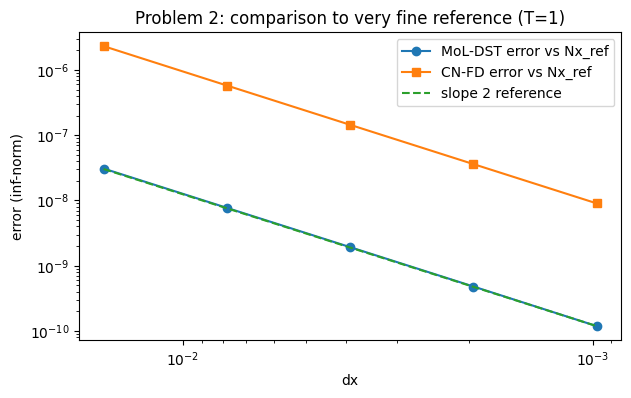

In [66]:
# Problem 2: comparison vs very fine reference (inf-norm errors and orders)
import numpy as np
import matplotlib.pyplot as plt

T = 1.0
Nx_ref = 8193  # very fine grid treated as exact
x_ref, u_ref = mol_dst(T, Nx_ref)
xi_ref = x_ref[1:-1]

Nx_list = [65, 129, 257, 513, 1025]

DX = []
ERR_MOL = []
ERR_CNFD = []

for Nx_i in Nx_list:
    dx_i = 1.0 / (Nx_i - 1)
    # MoL-DST on coarse grid
    x_m, u_m = mol_dst(T, Nx_i)
    # CN-FD on coarse grid with dt ~ 0.5*dx
    x_c, u_c, dt_used, steps_used = cn_fd(T, Nx_i, dt=0.5*dx_i)

    # Interpolate reference onto coarse interior nodes
    xi_i = x_m[1:-1]
    u_ref_i = np.interp(xi_i, xi_ref, u_ref[1:-1])

    err_m = float(np.max(np.abs(u_m[1:-1] - u_ref_i)))
    err_c = float(np.max(np.abs(u_c[1:-1] - u_ref_i)))

    DX.append(dx_i)
    ERR_MOL.append(err_m)
    ERR_CNFD.append(err_c)

# Print results and observed orders
print(f"Reference Nx_ref={Nx_ref} (treated as exact). Convergence at T=1 (inf-norm):")
for Nx_i, dx_i, e_m, e_c in zip(Nx_list, DX, ERR_MOL, ERR_CNFD):
    print(f"Nx={Nx_i:5d}  dx={dx_i:.6f}  MoL-DST err={e_m:.3e}  CN-FD err={e_c:.3e}")

orders_m = [np.log(ERR_MOL[i]/ERR_MOL[i+1]) / np.log(DX[i]/DX[i+1]) for i in range(len(DX)-1)]
orders_c = [np.log(ERR_CNFD[i]/ERR_CNFD[i+1]) / np.log(DX[i]/DX[i+1]) for i in range(len(DX)-1)]
print("Observed orders (MoL-DST): ", [f"{o:.2f}" for o in orders_m])
print("Observed orders (CN-FD):  ", [f"{o:.2f}" for o in orders_c])

# Plot
plt.figure(figsize=(7,4))
plt.loglog(DX, ERR_MOL, 'o-', label='MoL-DST error vs Nx_ref')
plt.loglog(DX, ERR_CNFD, 's-', label='CN-FD error vs Nx_ref')
# Slope-2 reference
k2 = ERR_MOL[-1] / (DX[-1]**2)
ref2 = [k2 * (d**2) for d in DX]
plt.loglog(DX, ref2, '--', label='slope 2 reference')
plt.gca().invert_xaxis()
plt.xlabel('dx')
plt.ylabel('error (inf-norm)')
plt.title('Problem 2: comparison to very fine reference (T=1)')
plt.legend()
plt.show()
